In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd  
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict,train_test_split    

from sklearn.model_selection import cross_val_predict, KFold ,RandomizedSearchCV  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  
from sklearn.linear_model import LinearRegression  
from xgboost import XGBRegressor  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

import shap
shap.initjs()  #如果没有导入将不能正常可视化

In [3]:
# 读取CSV文件  
data = pd.read_csv('/kaggle/input/a241105/a1105.csv')  

In [4]:
data

Cmcent  Cr     Me   Ei     Ai   Ac     Li  Gy  Ct   Mpa
0       120  20    0.0    0  312.0  0.3  156.0  21   3   2.0
1       120  20   78.0   25  234.0  0.3  156.0  21   3   5.2
2       120  20  156.0   50  156.0  0.3  156.0  21   3   8.6
3       120  20  234.0   75   78.0  0.3  156.0  21   3   7.4
4       120  20  312.0  100    0.0  0.3  156.0  21   3   7.9
..      ...  ..    ...  ...    ...  ...    ...  ..  ..   ...
315     489  80    0.0    0   73.0  0.1   36.5  12  90  39.4
316     489  80   18.0   25   55.0  0.1   36.5  12  90  40.0
317     489  80   36.5   50   36.5  0.1   36.5  12  90  42.2
318     489  80   55.0   75   18.0  0.1   36.5  12  90  46.3
319     489  80   73.0  100    0.0  0.1   36.5  12  90  51.5

[320 rows x 10 columns]

In [5]:
data.dropna(inplace=True)
data.columns=['Cmcent','Cr','Me','Ei','Ai','Ac','Li','Gy','Ct','Mpa']
X = data.loc[:,['Cmcent','Cr','Me','Ei','Ai','Ac','Li','Gy','Ct']]
y = data.loc[:,['Mpa']]

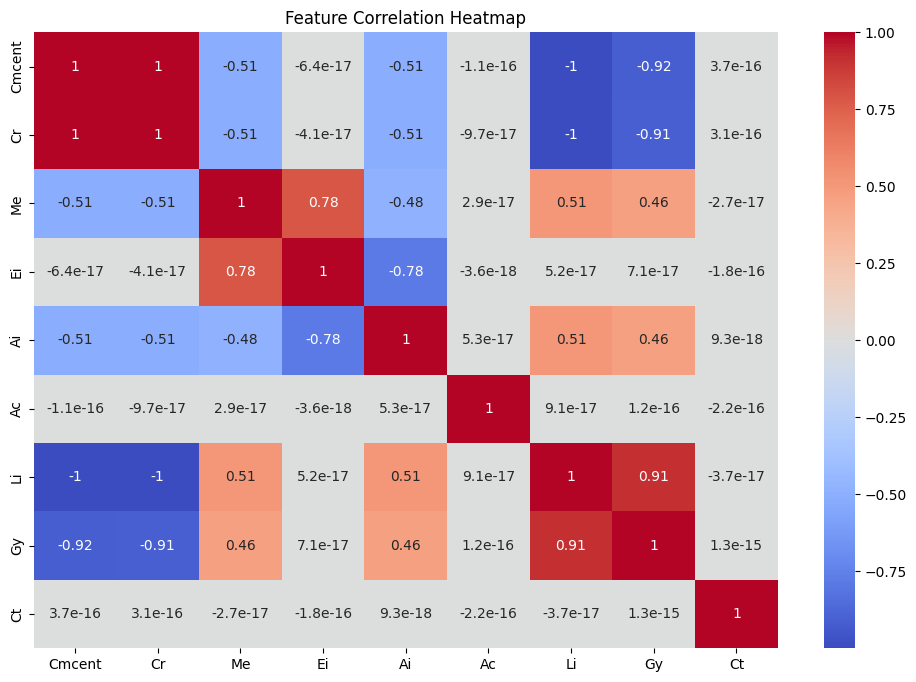

In [6]:
# 绘制特征的相关性热图  
plt.figure(figsize=(12, 8))  
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')  
plt.title('Feature Correlation Heatmap')  
plt.show()  

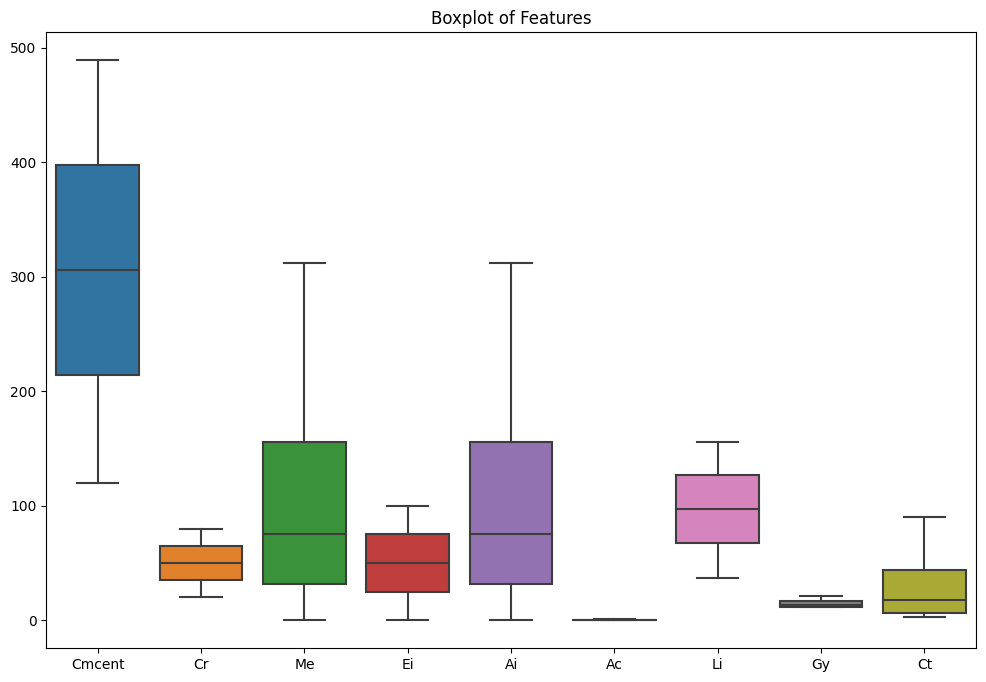

In [7]:
# 使用seaborn绘制箱型图
plt.figure(figsize=(12, 8))
sns.boxplot(data=X, orient="v")   #h水平绘图，v垂直绘图
plt.title('Boxplot of Features')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

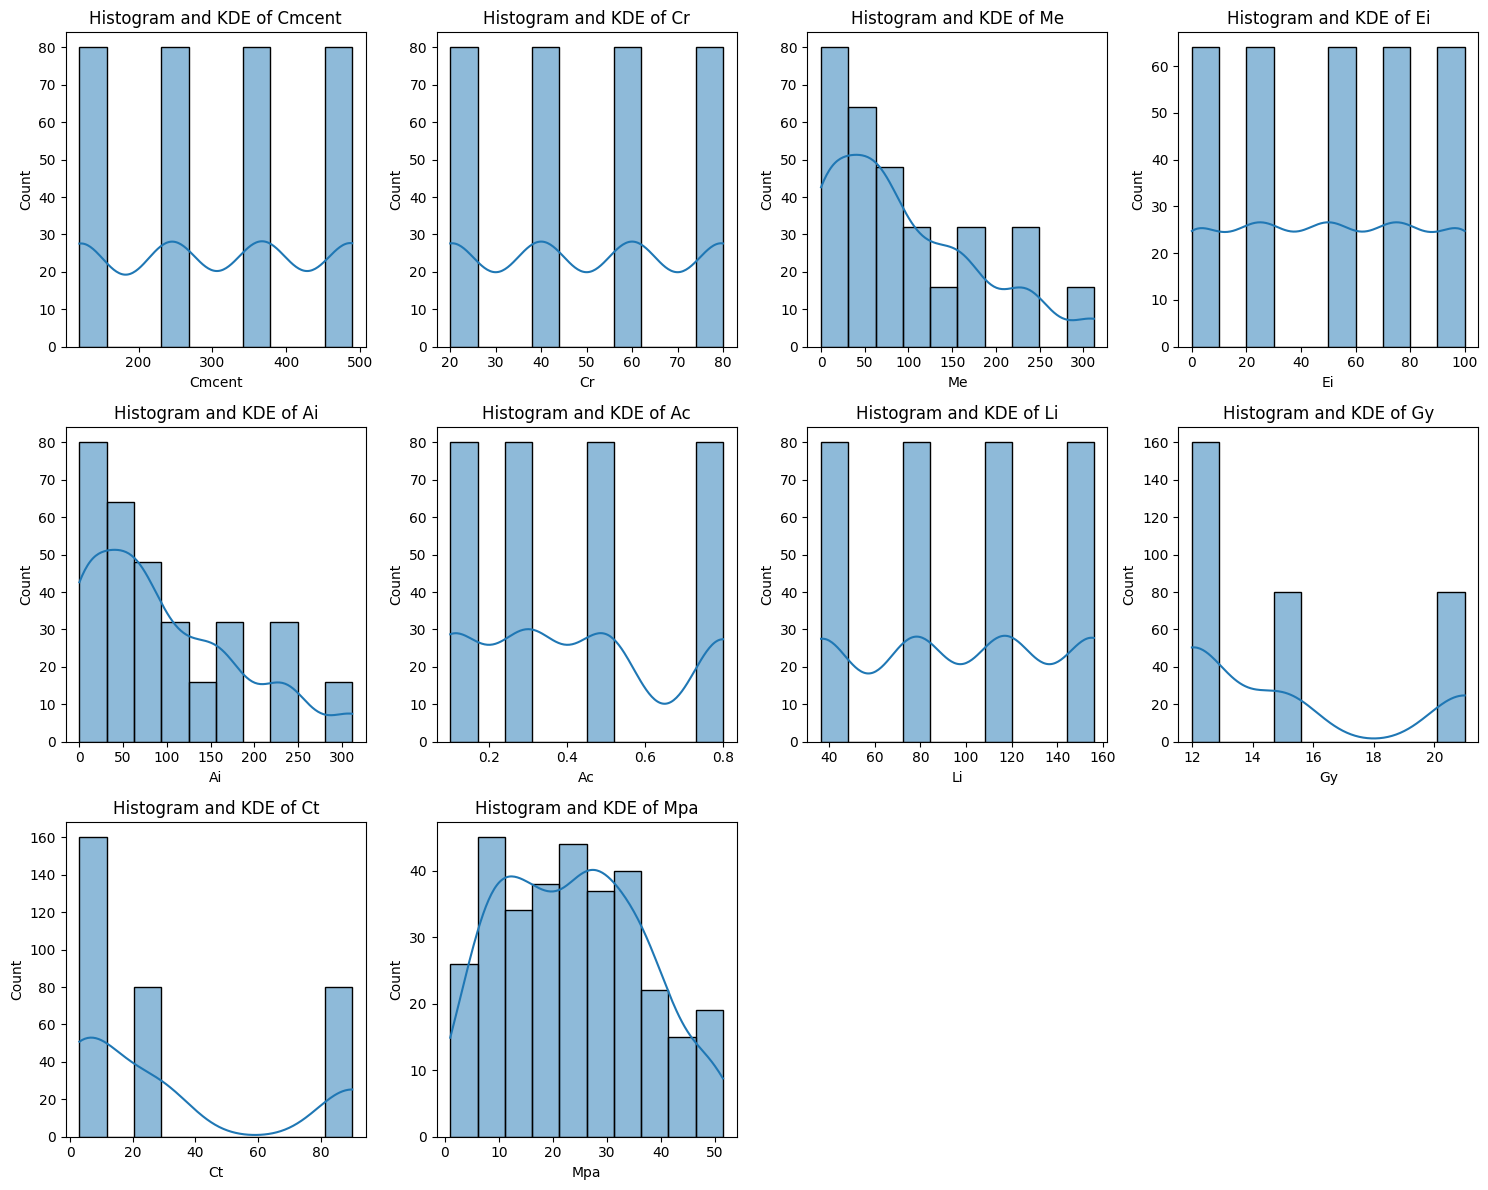

In [8]:
# 设置图形的大小
plt.figure(figsize=(15, 12))
 
# 遍历所有的列，包括特征列和标签列
for i, column in enumerate(data.columns):
    # 在子图上绘制直方图并拟合曲线
    plt.subplot(3, 4, i + 1)  # 3行4列的子图布局
    sns.histplot(data[column], kde=True)  # kde=True表示拟合曲线
    plt.title(f'Histogram and KDE of {column}')  # 设置子图的标题
 
# 调整子图之间的间距
plt.tight_layout()
 
# 显示图形
plt.show()

In [9]:
y.mean()

Mpa    23.634687
dtype: float64

In [10]:
# 定义交叉验证  
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

In [11]:
# 定义随机森林回归器的参数空间
param_distributions = {
    'n_estimators': randint(100, 500),  # 森林中的树木数量
    'max_depth': randint(10, 50),  # 树的最大深度，或者使用None表示不限深度（但这需要单独处理）
    'min_samples_split': randint(2, 20),  # 节点划分最少样本数
    'min_samples_leaf': randint(1, 20),  # 叶节点最少样本数
    'max_features': ['auto', 'sqrt', 'log2', None],  # 寻找最佳划分时要考虑的特征数量
    'bootstrap': [True, False],  # 构建树时是否使用样本放回抽样
    'oob_score': [True, False],  # 是否使用袋外样本来评估模型的泛化精度（仅在bootstrap=True时有效）
    'n_jobs': [-1],  # 并行运行的作业数，-1表示使用所有处理器
    'random_state': [42],  # 随机数生成器的种子，确保结果的可重复性
    'verbose': [0],  # 是否显示构建过程中的详细信息，0表示不显示
}
 
# 创建随机森林回归器实例
rf = RandomForestRegressor()
 
# 创建RandomizedSearchCV实例
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=kf, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
 
# 对数据进行随机搜索和交叉验证
random_search.fit(X, y.values.ravel())  # 注意y需要是一维数组
 
# 输出最佳参数组合
print("Best parameters found: ", random_search.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters found:  {'bootstrap': True, 'max_depth': 18, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 338, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0}


In [8]:
from scipy.stats import uniform, expon
# 定义支持向量回归器的参数空间
param_distributions = {
    'C': expon(scale=10),  # 正则化参数，控制模型的复杂性和对误差的容忍度
    'gamma': expon(scale=0.01),  # 核函数的系数，对于'rbf'核很重要
    'kernel': ['rbf', 'linear'],  # 只考虑径向基函数和线性核
    'tol': uniform(1e-4, 1e-3),  # 停止训练的误差容限
}
 
# 创建支持向量回归器实例
svr = SVR()
 
# 创建RandomizedSearchCV实例
random_search = RandomizedSearchCV(svr, param_distributions, n_iter=100, cv=kf, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
 
# 对数据进行随机搜索和交叉验证
random_search.fit(X, y.values.ravel())  # 注意y需要是一维数组
 
# 输出最佳参数组合
print("Best parameters found: ", random_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# 定义XGBoost回归器的参数空间
param_distributions = {
    'n_estimators': randint(100, 1000),  # 树的数量
    'learning_rate': uniform(0.01, 0.3),  # 学习率
    'max_depth': randint(3, 10),  # 树的最大深度
    'min_child_weight': uniform(0, 10),  # 叶子节点最小权重和
    'subsample': uniform(0.6, 1.0),  # 子样本比例
    'colsample_bytree': uniform(0.6, 1.0),  # 每棵树随机采样特征的比例
    'gamma': uniform(0, 5),  # 损失函数减少的最小值
    'reg_alpha': uniform(0, 1),  # L1正则化项
    'reg_lambda': uniform(0, 1),  # L2正则化项
    'nthread': [-1],  # 线程数，-1表示使用所有可用的线程
    'random_state': [42],  # 随机数生成器的种子
}
 
# 创建XGBoost回归器实例
xgb_reg = XGBRegressor(objective='reg:squarederror')  # 目标函数为平方误差
 
# 创建RandomizedSearchCV实例
random_search = RandomizedSearchCV(xgb_reg, param_distributions, n_iter=100, cv=kf, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
 
# 对数据进行随机搜索和交叉验证
random_search.fit(X, y)
 
# 输出最佳参数组合
print("Best parameters found: ", random_search.best_params_)

In [8]:
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100,          # 树的数量，通常越多越好，但计算成本也更高
        max_depth=10,              # 树的最大深度，控制过拟合
        min_samples_split=2,       # 节点划分最少样本数
        min_samples_leaf=1,        # 叶子节点最少样本数
        max_features='auto',       # 寻找最佳划分时要考虑的特征数量
        random_state=42            # 随机数生成器的种子，确保结果可重复
    ),
    'SVR': SVR(
        C=1.0,                     # 正则化参数，C越大，正则化越弱
        epsilon=0.1,               # 误差容忍度，控制模型的复杂度和准确性之间的平衡
        kernel='rbf',              # 核函数类型，'rbf'表示径向基函数
        gamma='scale',             # 核函数的系数，'scale'表示使用1 / (n_features * X.var())作为gamma的值
    ),
    'LinearRegression': LinearRegression(
        fit_intercept=True,        # 是否计算截距项
        copy_X=True,               # 是否复制X，如果False，会覆盖输入数据
        n_jobs=None                # 使用的CPU核数量，None表示使用所有可用的核
    ),
    'XGBRegressor': XGBRegressor(
        objective='reg:squarederror',  # 目标函数，这里是平方误差
        n_estimators=100,              # 树的数量
        learning_rate=0.1,             # 学习率
        max_depth=3,                   # 树的最大深度
        min_child_weight=1,            # 叶子节点最小权重和
        subsample=0.8,                 # 子样本比例
        colsample_bytree=0.8,          # 每棵树随机采样特征的比例
        gamma=0,                       # 损失函数减少的最小值
        reg_alpha=0,                   # L1正则化项
        reg_lambda=1,                  # L2正则化项
        random_state=42                # 随机数生成器的种子
    )
}

# 存储每个新模型的评估指标
results = {}
 
# 对每个新模型进行交叉验证并计算评估指标
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 交叉验证设置
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X, y.values.ravel(), cv=kf)
    errors = y.values.ravel() - y_pred  # 计算预测误差
    mse = mean_squared_error(y.values.ravel(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y.values.ravel(), y_pred)
    # 计算 MAPE 需要确保 y 不包含零值
    mape = np.mean(np.abs(errors / y.values.ravel())) * 100
    r2 = r2_score(y.values.ravel(), y_pred)
    std_deviation = np.std(errors)  # 计算预测误差的标准差
    
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Std Deviation': std_deviation  # 添加标准差到结果字典中
    }
 
# 打印新模型的结果
print("Results for models:")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.4f}%")
    print(f"R2: {metrics['R2']:.4f}")
    print(f"Std Deviation: {metrics['Std Deviation']:.4f}")  # 打印标准差
    print()

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Results for models:
Model: RandomForest
MSE: 4.6347
RMSE: 2.1528
MAE: 1.5082
MAPE: 9.2088%
R2: 0.9727
Std Deviation: 2.1498

Model: SVR
MSE: 33.4786
RMSE: 5.7861
MAE: 4.5244
MAPE: 28.4804%
R2: 0.8029
Std Deviation: 5.7677

Model: LinearRegression
MSE: 22.4198
RMSE: 4.7350
MAE: 3.7291
MAPE: 27.9117%
R2: 0.8680
Std Deviation: 4.7349

Model: XGBRegressor
MSE: 3.8855
RMSE: 1.9712
MAE: 1.4567
MAPE: 9.3080%
R2: 0.9771
Std Deviation: 1.9707



In [44]:
# 定义新的模型集合，使用默认参数
r_models = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor()
}
 
# 存储每个新模型的评估指标
r_results = {}
 
# 对每个新模型进行交叉验证并计算评估指标
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 示例交叉验证设置
for model_name, model in r_models.items():
    y_pred = cross_val_predict(model, X, y.values.ravel(), cv=kf)
    mse = mean_squared_error(y.values.ravel(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y.values.ravel(), y_pred)
    # 计算 MAPE 需要确保 y 不包含零值
    mape = np.mean(np.abs((y.values.ravel() - y_pred) / y.values.ravel())) * 100
    r2 = r2_score(y.values.ravel(), y_pred)
    # 计算预测标准差
    std_deviation = np.std(y.values.ravel() - y_pred)
    
    r_results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Std Deviation': std_deviation
    }
 
# 打印新模型的结果
print("Results for r_models:")
for model_name, metrics in r_results.items():
    print(f"Model: {model_name}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.4f}%")
    print(f"R2: {metrics['R2']:.4f}")
    print(f"Std Deviation: {metrics['Std Deviation']:.4f}")
    print()

Results for r_models:
Model: RandomForest
MSE: 4.7936
RMSE: 2.1894
MAE: 1.5267
MAPE: 9.1400%
R2: 0.9718
Std Deviation: 2.1866

Model: SVR
MSE: 33.4786
RMSE: 5.7861
MAE: 4.5244
MAPE: 28.4804%
R2: 0.8029
Std Deviation: 5.7677

Model: LinearRegression
MSE: 22.4198
RMSE: 4.7350
MAE: 3.7291
MAPE: 27.9117%
R2: 0.8680
Std Deviation: 4.7349

Model: XGBRegressor
MSE: 3.4798
RMSE: 1.8654
MAE: 1.3275
MAPE: 8.0530%
R2: 0.9795
Std Deviation: 1.8654



In [54]:
# 定义评估指标计算函数
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_pred - y_true)
    return mse, mae, rmse, mape, r2, std_dev
 

In [60]:
X = data.loc[:, ['Cmcent', 'Cr', 'Me', 'Ei', 'Ai', 'Ac', 'Li', 'Gy', 'Ct']]
y = data['Mpa']

In [61]:
 
# 有截距的线性回归
model_with_intercept = LinearRegression(fit_intercept=True)
y_pred_with_intercept = cross_val_predict(model_with_intercept, X, y, cv=kf)
metrics_with_intercept = calculate_metrics(y, y_pred_with_intercept)
print("有截距时的评估指标:")
print(f"MSE: {metrics_with_intercept[0]}")
print(f"MAE: {metrics_with_intercept[1]}")
print(f"RMSE: {metrics_with_intercept[2]}")
print(f"MAPE: {metrics_with_intercept[3]}%")
print(f"R²: {metrics_with_intercept[4]}")
print(f"Std Deviation: {metrics_with_intercept[5]}")
 

有截距时的评估指标:
MSE: 22.419807837311005
MAE: 3.72908659619943
RMSE: 4.734955948824762
MAPE: 27.911692472622953%
R²: 0.8679794884314956
Std Deviation: 4.734908771445226


In [62]:
# 拟合有截距的线性回归方程
model_with_intercept.fit(X, y)
coef_with_intercept = model_with_intercept.coef_
intercept_with_intercept = model_with_intercept.intercept_
print("有截距时的线性回归方程:")
print(f"Mpa = {intercept_with_intercept} + " +
      " + ".join([f"{coef}*{feature}" for coef, feature in zip(coef_with_intercept, X.columns)]))
 

有截距时的线性回归方程:
Mpa = -215.17582918830544 + 0.37109880957612207*Cmcent + 0.2823478196000617*Cr + 0.08998061090530227*Me + 0.1892898204114411*Ei + 0.1010968662831129*Ai + -4.4031542056074775*Ac + 0.9133875806159784*Li + -0.4478882775591436*Gy + 0.11153812422616625*Ct


In [63]:
# 无截距的线性回归
model_without_intercept = LinearRegression(fit_intercept=False)
y_pred_without_intercept = cross_val_predict(model_without_intercept, X, y, cv=kf)
metrics_without_intercept = calculate_metrics(y, y_pred_without_intercept)
print("无截距时的评估指标:")
print(f"MSE: {metrics_without_intercept[0]}")
print(f"MAE: {metrics_without_intercept[1]}")
print(f"RMSE: {metrics_without_intercept[2]}")
print(f"MAPE: {metrics_without_intercept[3]}%")
print(f"R²: {metrics_without_intercept[4]}")
print(f"Std Deviation: {metrics_without_intercept[5]}")
 

无截距时的评估指标:
MSE: 22.419807837310994
MAE: 3.7290865961994277
RMSE: 4.734955948824761
MAPE: 27.911692472623002%
R²: 0.8679794884314957
Std Deviation: 4.734908771445225


In [64]:
# 拟合无截距的线性回归方程
model_without_intercept.fit(X, y)
coef_without_intercept = model_without_intercept.coef_
print("无截距时的线性回归方程:")
print("Mpa = " + " + ".join([f"{coef}*{feature}" for coef, feature in zip(coef_without_intercept, X.columns)]))

无截距时的线性回归方程:
Mpa = 0.013043943424978827*Cmcent + 0.33470518012248784*Cr + -0.41830656380149656*Me + 0.18928982041143846*Ei + -0.40719030842368753*Ai + -4.403154205607469*Ac + 0.8903514810007218*Li + -0.97537220194558*Gy + 0.11153812422616621*Ct


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


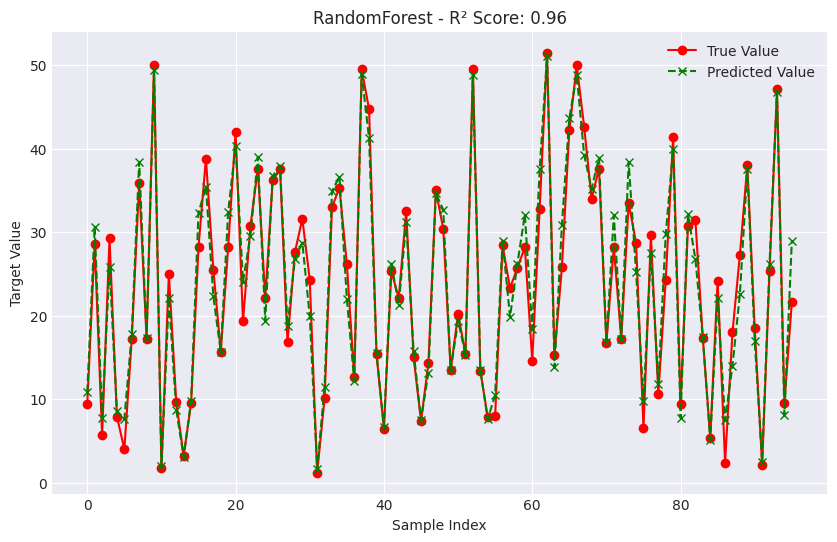

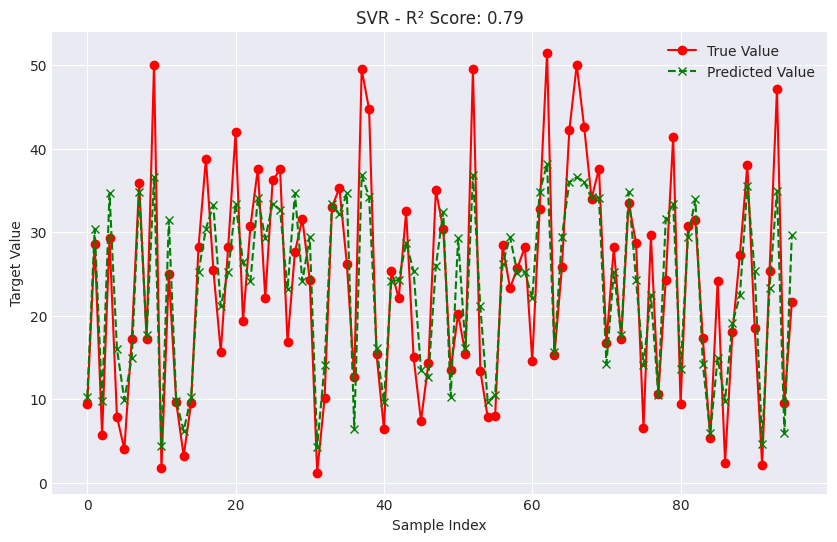

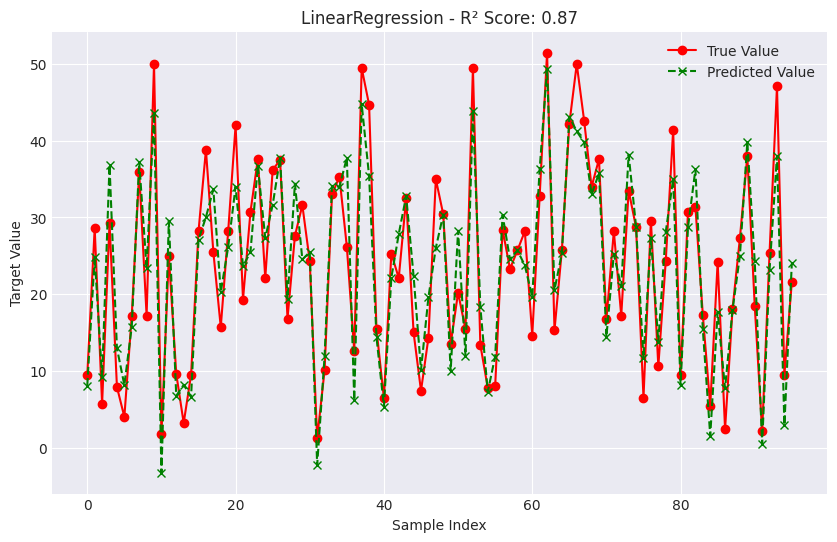

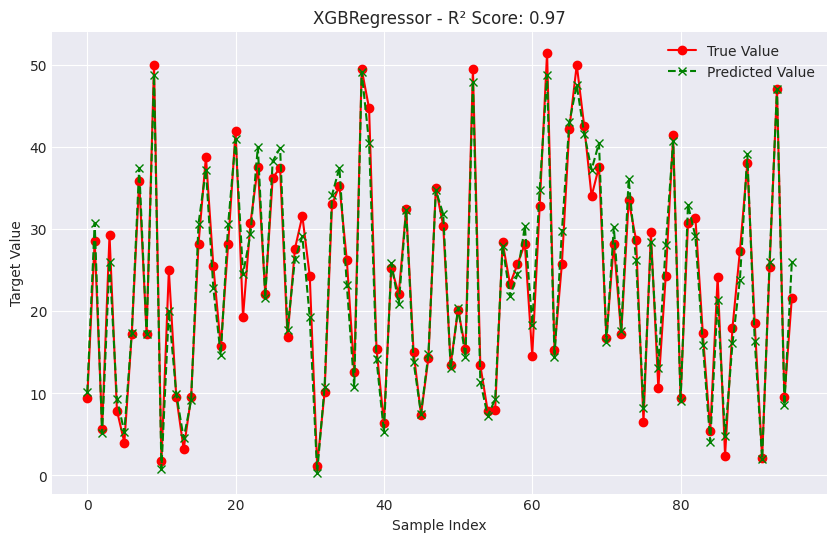

In [38]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 初始化一个字典来存储每个模型的预测值和真实值
model_predictions = {}
 
# 遍历模型，进行训练、预测，并收集预测值
for model_name, model in models.items():
    model.fit(X_train, y_train.values.ravel())  # 对于某些模型，y需要是一维数组
    y_pred = model.predict(X_test)
    model_predictions[model_name] = (y_test.values.ravel(), y_pred)
 
# 绘制每个模型的图像
for model_name, (y_true, y_pred) in model_predictions.items():
    r2 = r2_score(y_true, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_pred)), y_true, color="red", marker="o", label="True Value", linestyle="-")
    plt.plot(np.arange(len(y_pred)), y_pred, color="green", marker="x", label="Predicted Value", linestyle="--")
    plt.title(f"{model_name} - R² Score: {r2:.2f}")
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

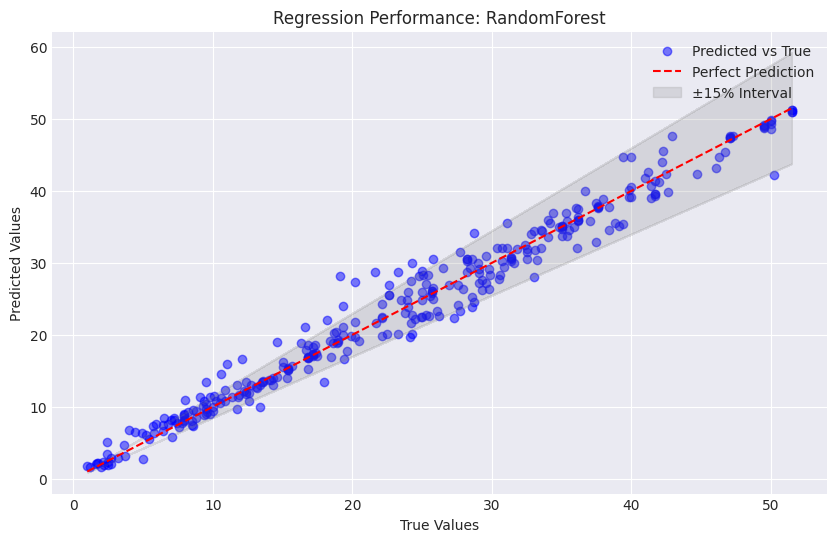

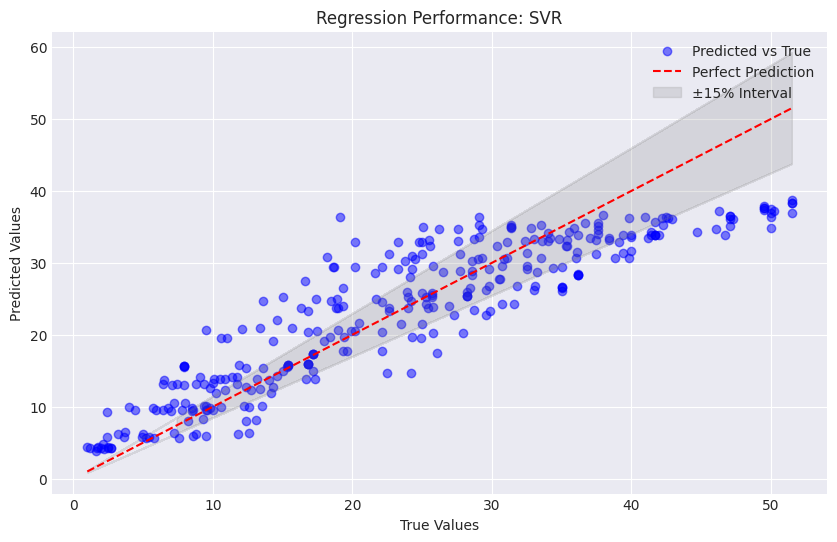

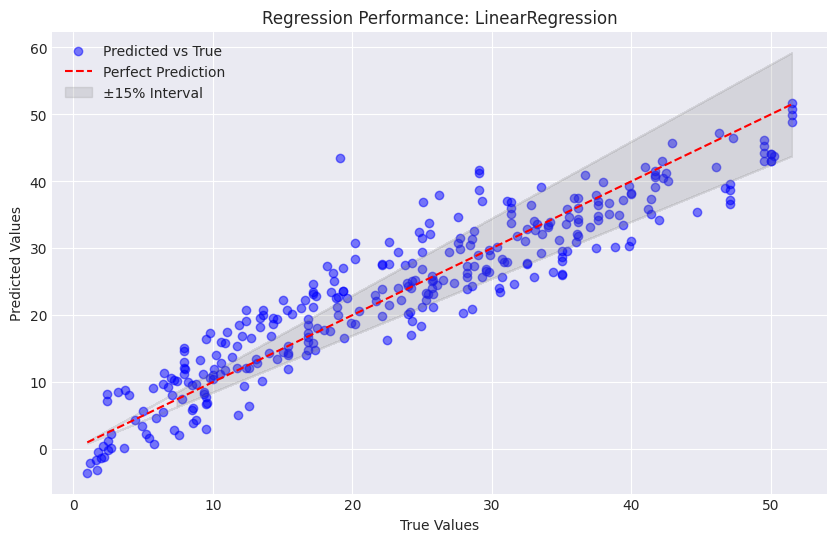

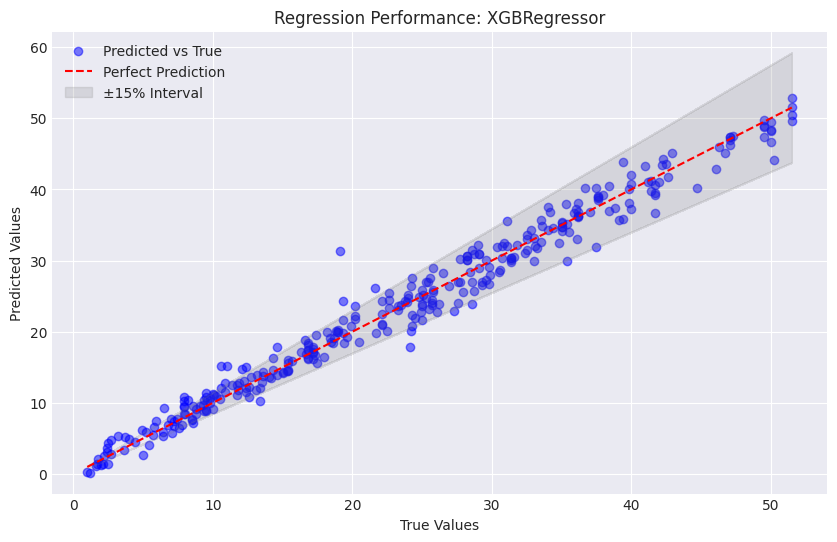

In [39]:
# 初始化一个字典来存储每个模型的预测值和真实值
model_predictions = {model_name: [] for model_name in models.keys()}
 
# 遍历模型，进行交叉验证，并收集预测值
for model_name, model in models.items():
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_test)
        
        # 存储预测值和真实值
        model_predictions[model_name].append((y_test.values.ravel(), y_pred))
 
# 绘制每个模型的回归性能对比图
for model_name, predictions in model_predictions.items():
    y_true_all = np.concatenate([p[0] for p in predictions])
    y_pred_all = np.concatenate([p[1] for p in predictions])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_all, y_pred_all, color="blue", marker="o", alpha=0.5, label="Predicted vs True")
    plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], color="red", linestyle="--", label="Perfect Prediction")
    
    # 计算正负15%区间
    lower_bound = y_true_all * 0.85
    upper_bound = y_true_all * 1.15
    plt.fill_between(y_true_all, lower_bound, upper_bound, color="gray", alpha=0.2, label="±15% Interval")
    
    plt.title(f"Regression Performance: {model_name}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: Future

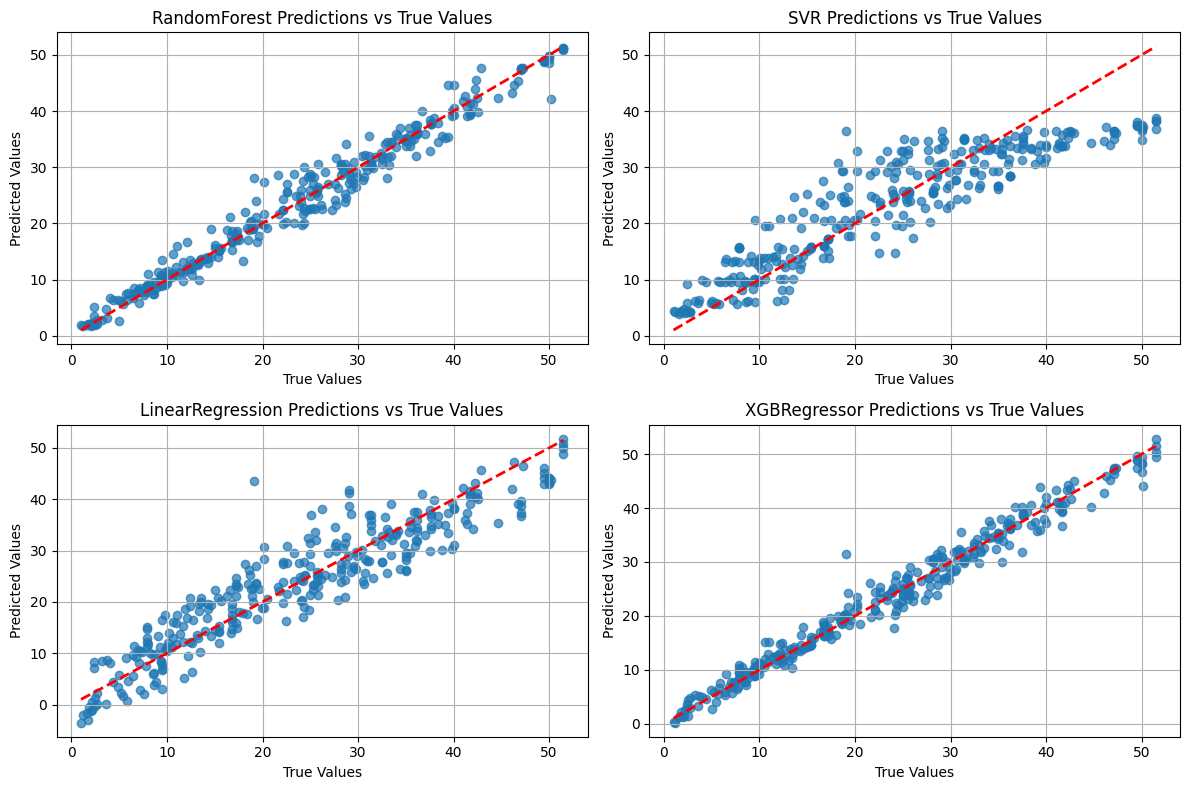

In [26]:
# 存储每个模型的预测值
predictions = {}
 
# 对每个模型进行交叉验证并存储预测值
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    predictions[model_name] = y_pred
 
# 绘制散点图
plt.figure(figsize=(12, 8))
for i, (model_name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(y, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)  # 45度线
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predictions vs True Values')
    plt.grid(True)
 
# 调整子图布局
plt.tight_layout()
 
# 显示图形
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed

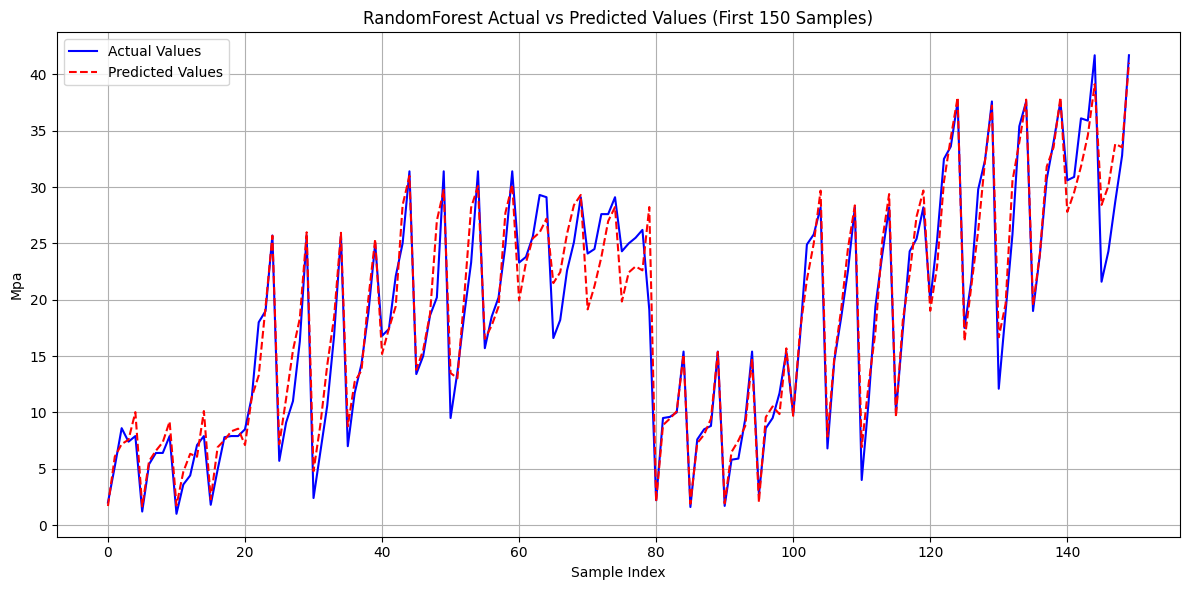

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

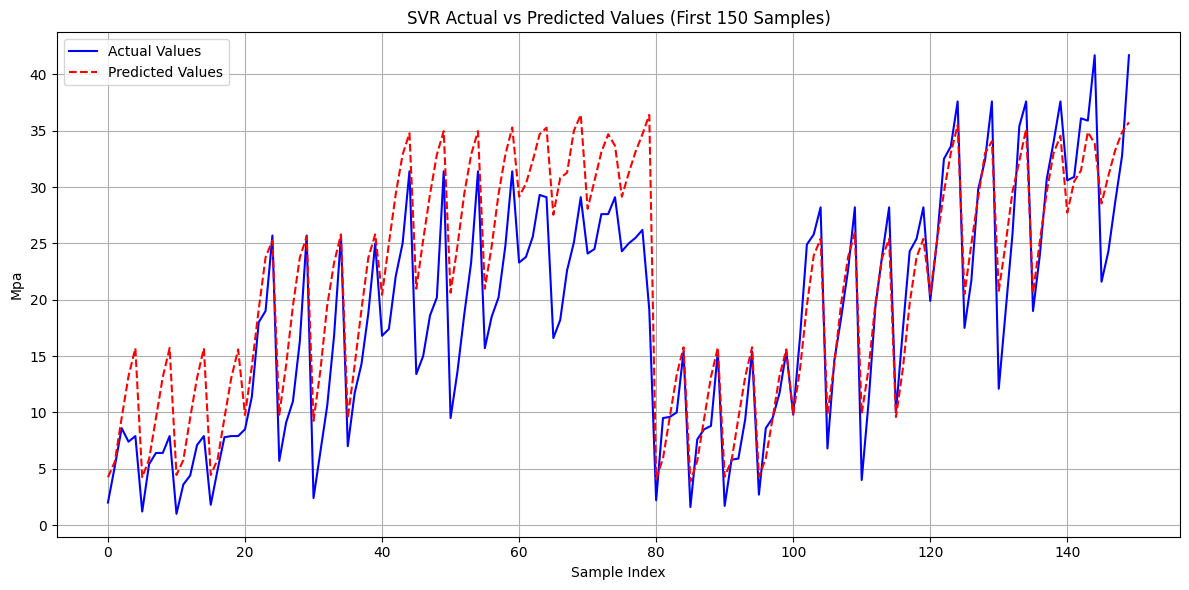

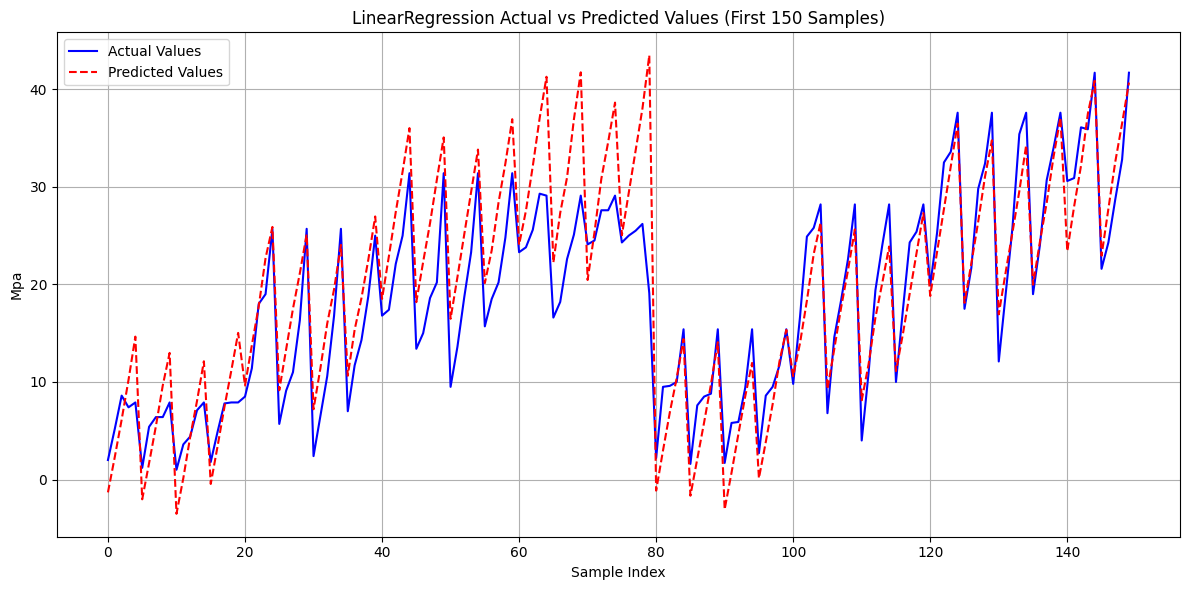

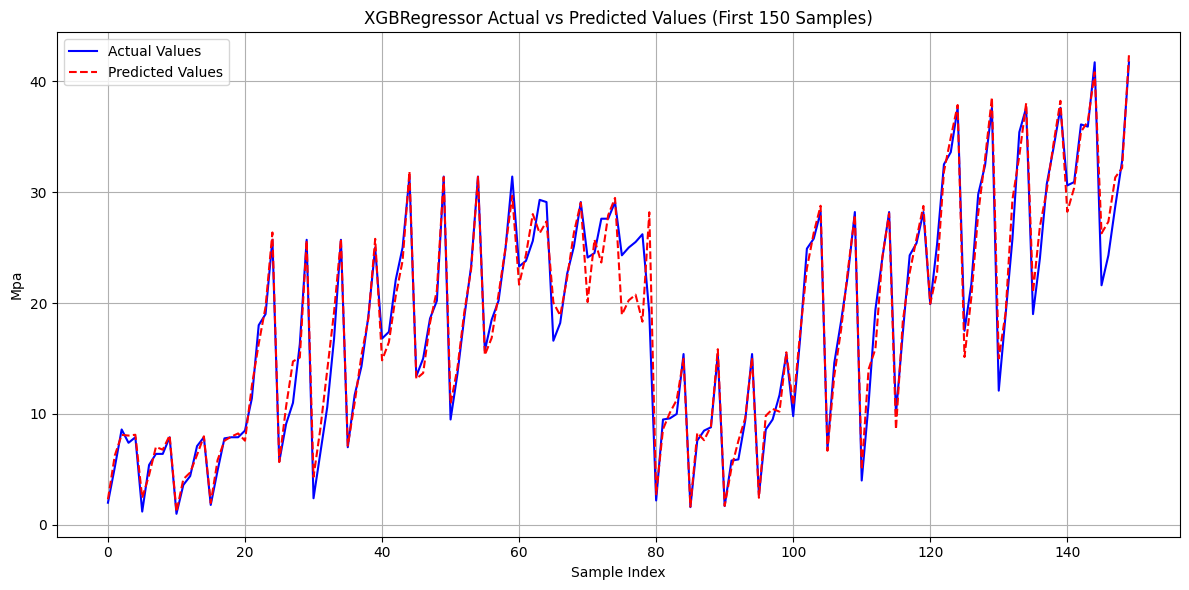

In [45]:
num_samples_to_plot = 150  # 要绘制的样本数量  
  
# 遍历模型，进行交叉验证并绘制图形  
for name, model in models.items():  
    # 交叉验证预测  
    y_pred = cross_val_predict(model, X, y, cv=kf)  
      
    # 确保有足够的样本可供绘制  
    if len(y) < num_samples_to_plot:  
        print(f"Warning: Not enough samples to plot {num_samples_to_plot} points for model {name}. Plotting all {len(y)} samples.")  
        num_samples_to_plot = len(y)  
      
    # 切片以只取前 num_samples_to_plot 个样本  
    y_true_slice = y[:num_samples_to_plot]  
    y_pred_slice = y_pred[:num_samples_to_plot]  
      
    # 绘制真实值和预测值的折线图  
    plt.figure(figsize=(12, 6))  
    plt.plot(y_true_slice, label='Actual Values', color='blue')  
    plt.plot(y_pred_slice, label='Predicted Values', color='red', linestyle='--')  
      
    plt.xlabel('Sample Index')  
    plt.ylabel('Mpa')  # 假设你的目标变量是以 Mpa 为单位的  
    plt.title(f'{name} Actual vs Predicted Values (First {num_samples_to_plot} Samples)')  
    plt.legend()  
    plt.grid(True)  
    plt.tight_layout()  
    plt.savefig(f'{name}_actual_vs_predicted_{num_samples_to_plot}_samples.png')  # 保存图像文件，包含样本数量信息  
    plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# 训练 CatBoost 模型
XGBR = XGBRegressor(
        objective='reg:squarederror',  # 目标函数，这里是平方误差
        n_estimators=100,              # 树的数量
        learning_rate=0.1,             # 学习率
        max_depth=3,                   # 树的最大深度
        min_child_weight=1,            # 叶子节点最小权重和
        subsample=0.8,                 # 子样本比例
        colsample_bytree=0.8,          # 每棵树随机采样特征的比例
        gamma=0,                       # 损失函数减少的最小值
        reg_alpha=0,                   # L1正则化项
        reg_lambda=1,                  # L2正则化项
        random_state=42                # 随机数生成器的种子
    )
XGBR.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
# 解释器
explainer = shap.TreeExplainer(XGBR)

In [25]:
shap_values = explainer(X_test)

In [26]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

In [45]:
sample_features = X_test.iloc[16]
sample_features

Cmcent    367.0
Cr         60.0
Me         77.5
Ei         50.0
Ai         77.5
Ac          0.3
Li         78.0
Gy         12.0
Ct         28.0
Name: 202, dtype: float64

In [47]:
sample_true_value = y_test.iloc[16][0]
sample_true_value

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


38.8

In [39]:
sample_pre_value = XGBR.predict([sample_features])[0]
sample_pre_value

38.073086

**将上述功能定义为一个函数**

In [48]:
"""
    检索指定样本的特征、真实值、预测值以及SHAP值。
    
    参数:
    sample_index (int): 样本索引（从0开始）
    
    返回:
    dict: 包含样本特征、真实值、预测值和SHAP值的字典
    """

def get_sample_info(sample_index):
    
    # 检索样本特征
    sample_features = X_test.iloc[sample_index]
    
    # 检索样本真实值
    sample_true_value = y_test.iloc[sample_index][0]
    
    # 预测样本值
    sample_pre_value = XGBR.predict([sample_features])[0]
    
    # 检索样本的SHAP值
    sample_shap_values = shap_values[sample_index]
    
    # 返回包含所有信息的字典
    return {
        "features": sample_features,
        "true_value": sample_true_value,
        "predicted_value": sample_pre_value,
        "shap_values": sample_shap_values
    }

In [49]:
get_sample_info(16)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


{'features': Cmcent    367.0
 Cr         60.0
 Me         77.5
 Ei         50.0
 Ai         77.5
 Ac          0.3
 Li         78.0
 Gy         12.0
 Ct         28.0
 Name: 202, dtype: float64,
 'true_value': 38.8,
 'predicted_value': 38.073086,
 'shap_values': .values =
 array([ 3.621849  ,  1.1185187 ,  0.75007695, -0.8805389 ,  3.4693174 ,
         2.4301867 , -0.01704752,  0.        ,  4.10386   ], dtype=float32)
 
 .base_values =
 23.47687
 
 .data =
 array([3.67e+02, 6.00e+01, 7.75e+01, 5.00e+01, 7.75e+01, 3.00e-01,
        7.80e+01, 1.20e+01, 2.80e+01])}

In [15]:
shap_values[16]

.values =
array([ 4.290146  ,  1.4242055 , -2.010148  , -1.5464423 ,  3.472193  ,
        2.4967995 ,  0.05188375,  0.        ,  3.4648268 ], dtype=float32)

.base_values =
23.47687

.data =
array([4.89e+02, 8.00e+01, 0.00e+00, 0.00e+00, 7.30e+01, 3.00e-01,
       3.65e+01, 1.20e+01, 2.80e+01])

In [58]:
shap.plots.force(shap_values[18,...])  #这里的数字116代表样本索引，表示第17组样本

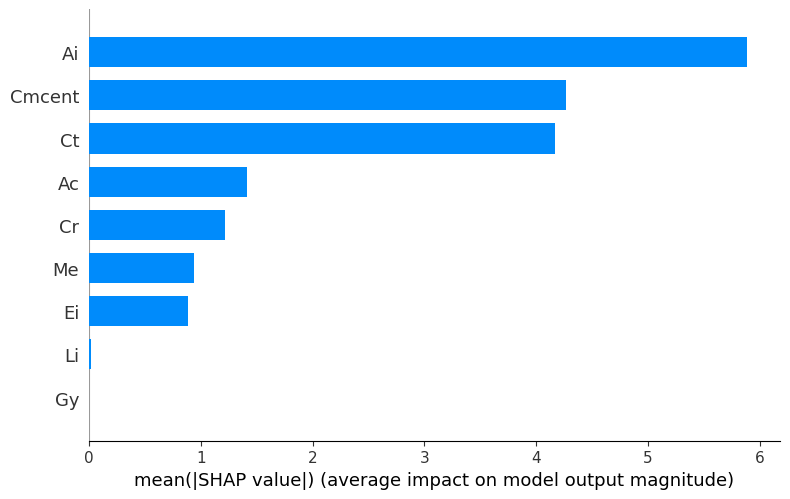

In [51]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

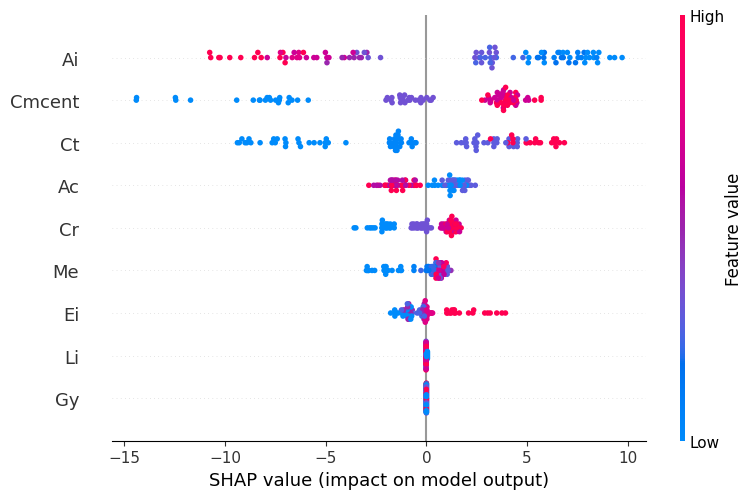

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

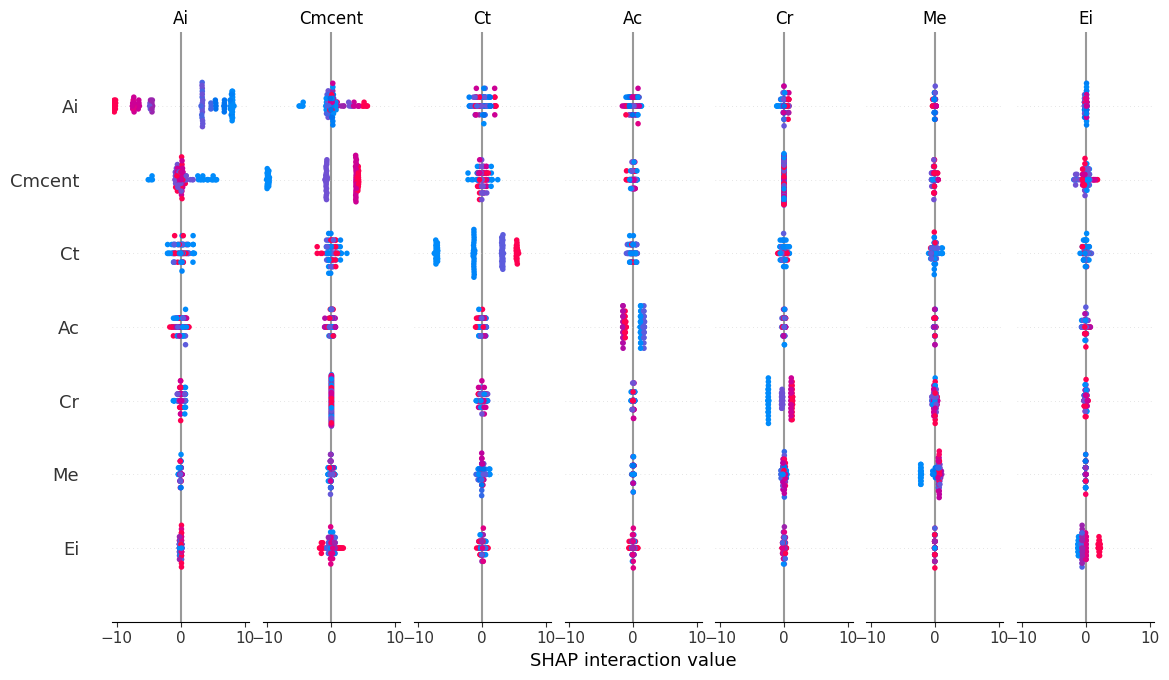

In [53]:
shap.summary_plot(shap_interaction_values, X_test)

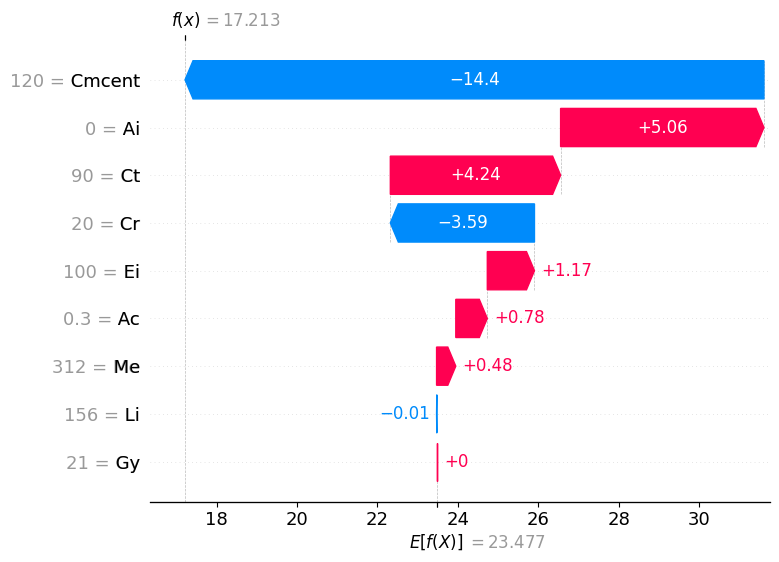

In [60]:
shap.plots.waterfall(shap_values[8])